# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Import-and-Preprocessing" data-toc-modified-id="Data-Import-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Import and Preprocessing</a></div><div class="lev2 toc-item"><a href="#Distances" data-toc-modified-id="Distances-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Distances</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Using-Masked-kernels" data-toc-modified-id="Using-Masked-kernels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using Masked kernels</a></div><div class="lev1 toc-item"><a href="#Fixed-parameter-Kernel" data-toc-modified-id="Fixed-parameter-Kernel-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fixed parameter Kernel</a></div>

In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [74]:
include("src/preprocessing.jl")

read_Stations (generic function with 1 method)

In [76]:
isdList=read_isdList()
isdList[1:5,:]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,10010,99999,JAN MAYEN(NOR-NAVY),NO,,ENJA,70.933,-8.667,9.0,1931,2015,4.5545e6,6.11344e6
2,10060,99999,EDGEOYA,NO,,,78.25,22.817,14.0,1973,2015,4.04982e6,7.5564e6
3,10070,99999,NY-ALESUND,SV,,,78.917,11.933,7.7,1973,2015,3.8678e6,7.26549e6
4,10080,99999,LONGYEAR,SV,,ENSB,78.246,15.466,26.8,1975,2015,3.99705e6,7.33669e6
5,10090,99999,KARL XII OYA,SV,,,80.65,25.0,5.0,1955,2015,3.69259e6,7.68545e6


In [5]:
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [77]:
hourly_cat=read_Stations(isdSubset)
hourly_cat[1:5,:]

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.86667


## Distances

In [78]:
# http://www.johndcook.com/blog/python_longitude_latitude/
function distance_on_unit_sphere(lat1, long1, lat2, long2)
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = π/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cosangle = (sin(phi1)*sin(phi2)*cos(theta1 - theta2) +
           cos(phi1)*cos(phi2))
    arc = acos( cosangle )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc
end

distance_on_unit_sphere (generic function with 1 method)

In [79]:
numstations = nrow(isdSubset)
pairwiseD = zeros(numstations, numstations)
for i in 1:numstations
    for j in 1:i
        if i==j
            continue
        end
        station1 = isdSubset[i,:]
        station2 = isdSubset[j,:]
        lat1= get(station1[1,:LAT])
        lon1 = get(station1[1,:LON])
        lat2 = get(station2[1,:LAT])
        lon2 = get(station2[1,:LON])
        pairwiseD[i,j] = distance_on_unit_sphere(lat1, lon1, lat2, lon2)
        pairwiseD[j,i] = pairwiseD[i,j]
    end
end
pairwiseD

4×4 Array{Float64,2}:
 0.0        0.0259496  0.0146736  0.0303475
 0.0259496  0.0        0.024088   0.0285853
 0.0146736  0.024088   0.0        0.0158124
 0.0303475  0.0285853  0.0158124  0.0      

In [80]:
Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])

4×2 Array{Float64,2}:
 1.64799e6  1.0441e6 
 1.48723e6  1.00379e6
 1.59025e6  1.11766e6
 1.51407e6  1.18374e6

In [81]:
pairwise(Euclidean(), Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])')

4×4 Array{Float64,2}:
      0.0        165736.0        93510.4        1.93474e5
 165736.0             0.0            1.53559e5  1.81942e5
  93510.4             1.53559e5      0.0        1.00846e5
      1.93474e5       1.81942e5      1.00846e5  0.0      

In [82]:
pairwise(Euclidean(), Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])') ./ pairwiseD

4×4 Array{Float64,2}:
 NaN            6.38684e6    6.37271e6    6.37527e6
   6.38684e6  NaN            6.37493e6    6.36489e6
   6.37271e6    6.37493e6  NaN            6.37765e6
   6.37527e6    6.36489e6    6.37765e6  NaN        

# Kernel Specification

In [17]:
k1 = FixedPeriodic(0.0,0.0,0.0)
k2 = RQIso(0.0,0.0,0.0)
k3 = SEIso(0.0,0.0)
k4 = RQIso(0.0,0.0,0.0)
k5 = RQIso(0.0,0.0,0.0)
k6 = SE(0.0,0.0)
k_time=k1+k2+k3+k4+k5+k6
# hyperparameters fitted in JuliaGP_timeseries_chunks.ipynb
hyp=[-1.4693,-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
set_params!(k_time, hyp[2:end])

In [63]:
k_spatial = SEIso(log(2*10^5), log(1.0))

Type: GaussianProcesses.SEIso, Params: [12.2061,0.0]


In [19]:
cK_stations = cov(k_spatial, zeros(1,nstations), GaussianProcesses.IsotropicData(pairwiseD.^2))

4×4 Array{Float64,2}:
 1.0       0.810234  0.934928  0.749909
 0.810234  1.0       0.834167  0.774646
 0.934928  0.834167  1.0       0.92484 
 0.749909  0.774646  0.92484   1.0     

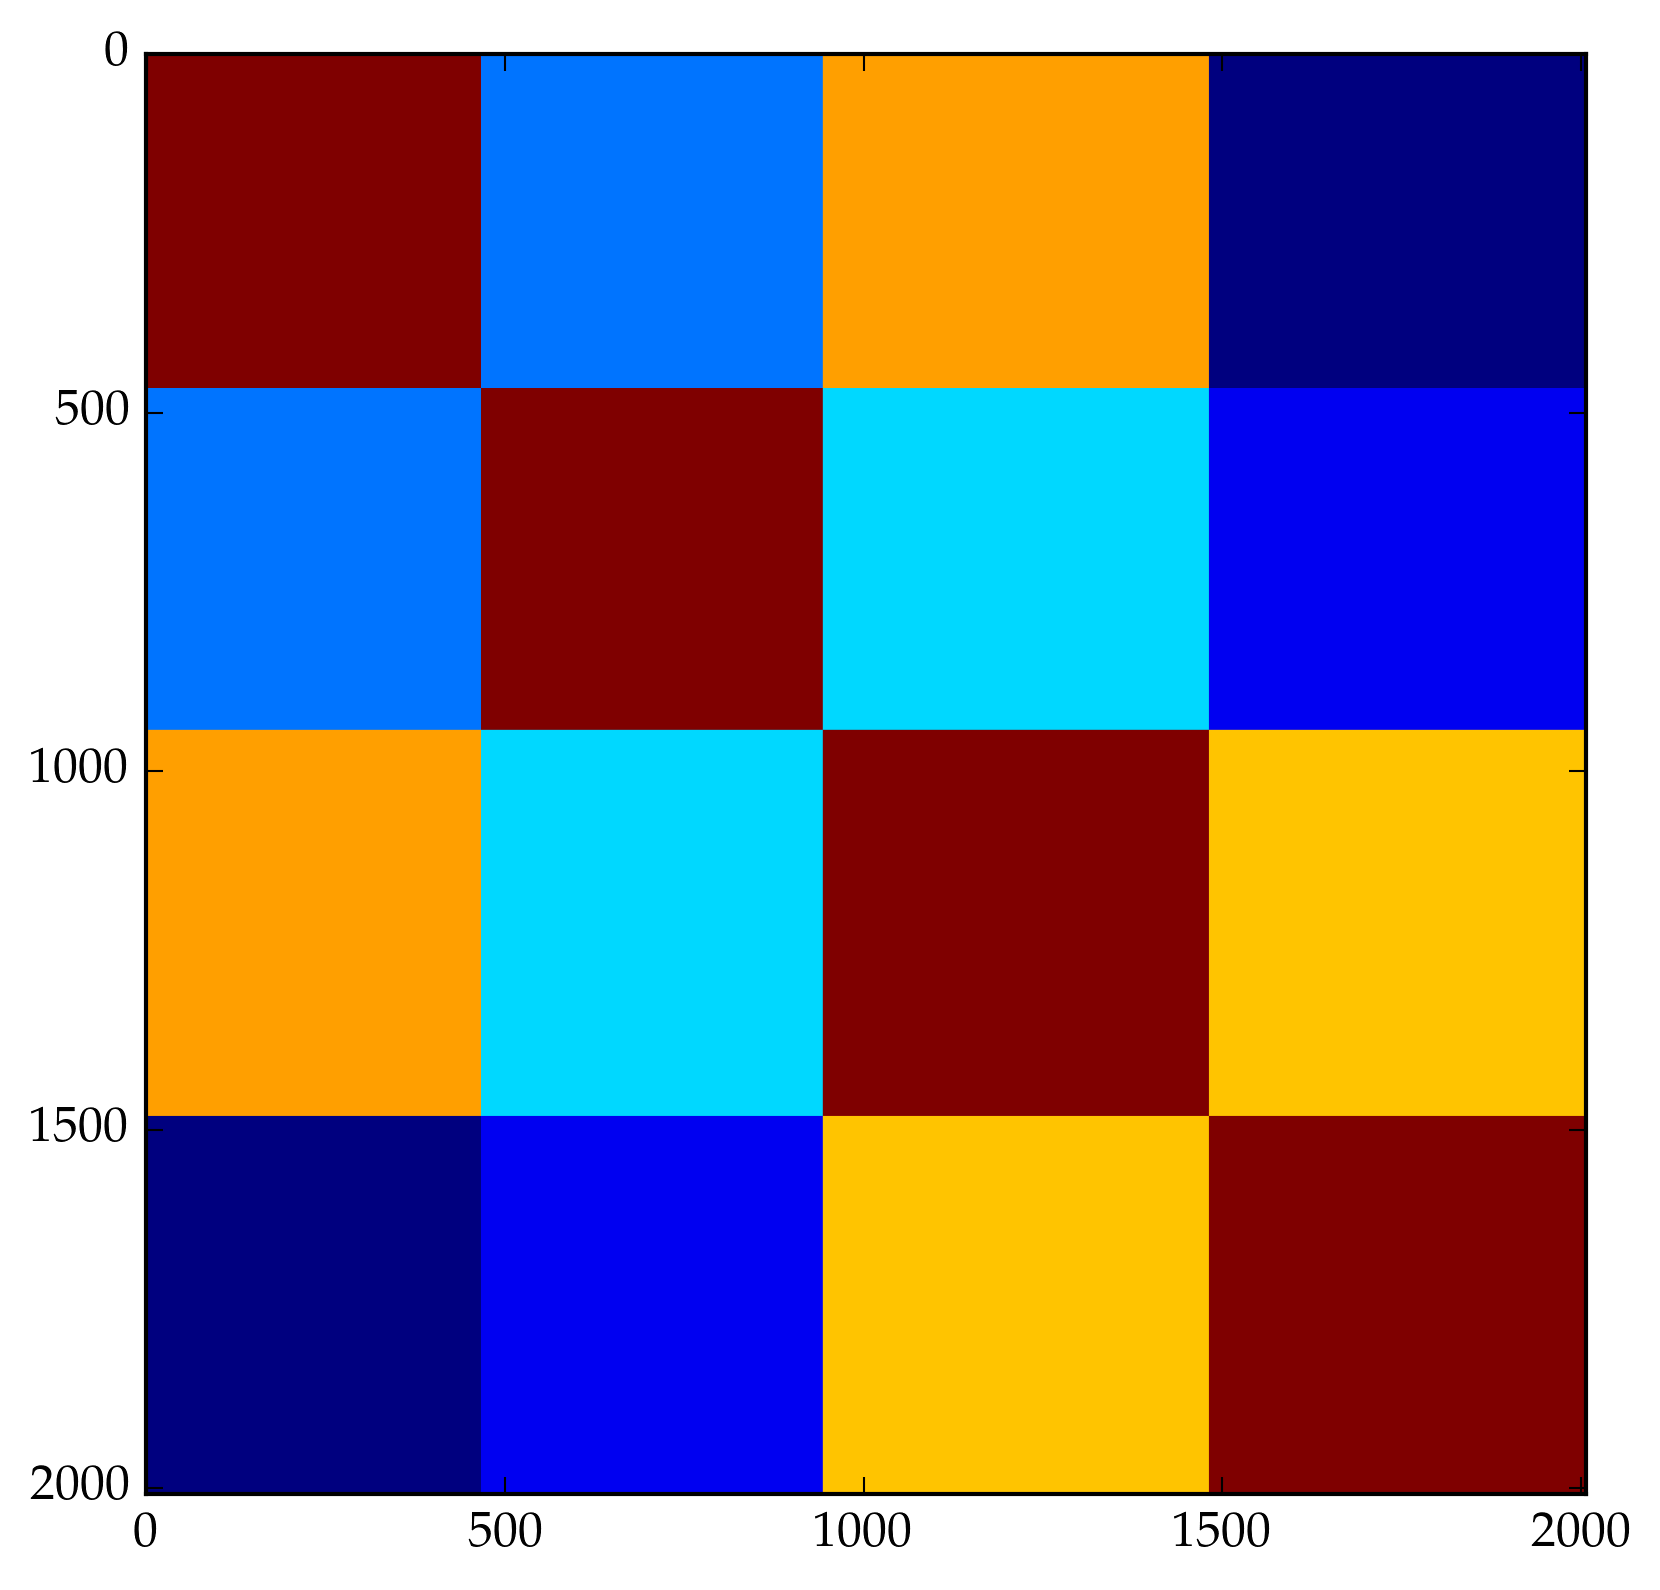

In [20]:
chunk_width=24*14
tstart=0.0
tend=tstart+chunk_width
in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
hourly_chunk = hourly_cat[in_chunk,:]
nobsv_chunk = sum(in_chunk)
station = convert(Vector{Int},hourly_chunk[:station])

cK_spatial = zeros(nobsv_chunk, nobsv_chunk)
for j in 1:nobsv_chunk
    for i in 1:j
        cK_spatial[i,j] = cK_stations[station[i], station[j]]
        cK_spatial[j,i] = cK_spatial[i,j]
    end
end
plt.imshow(cK_spatial)
;

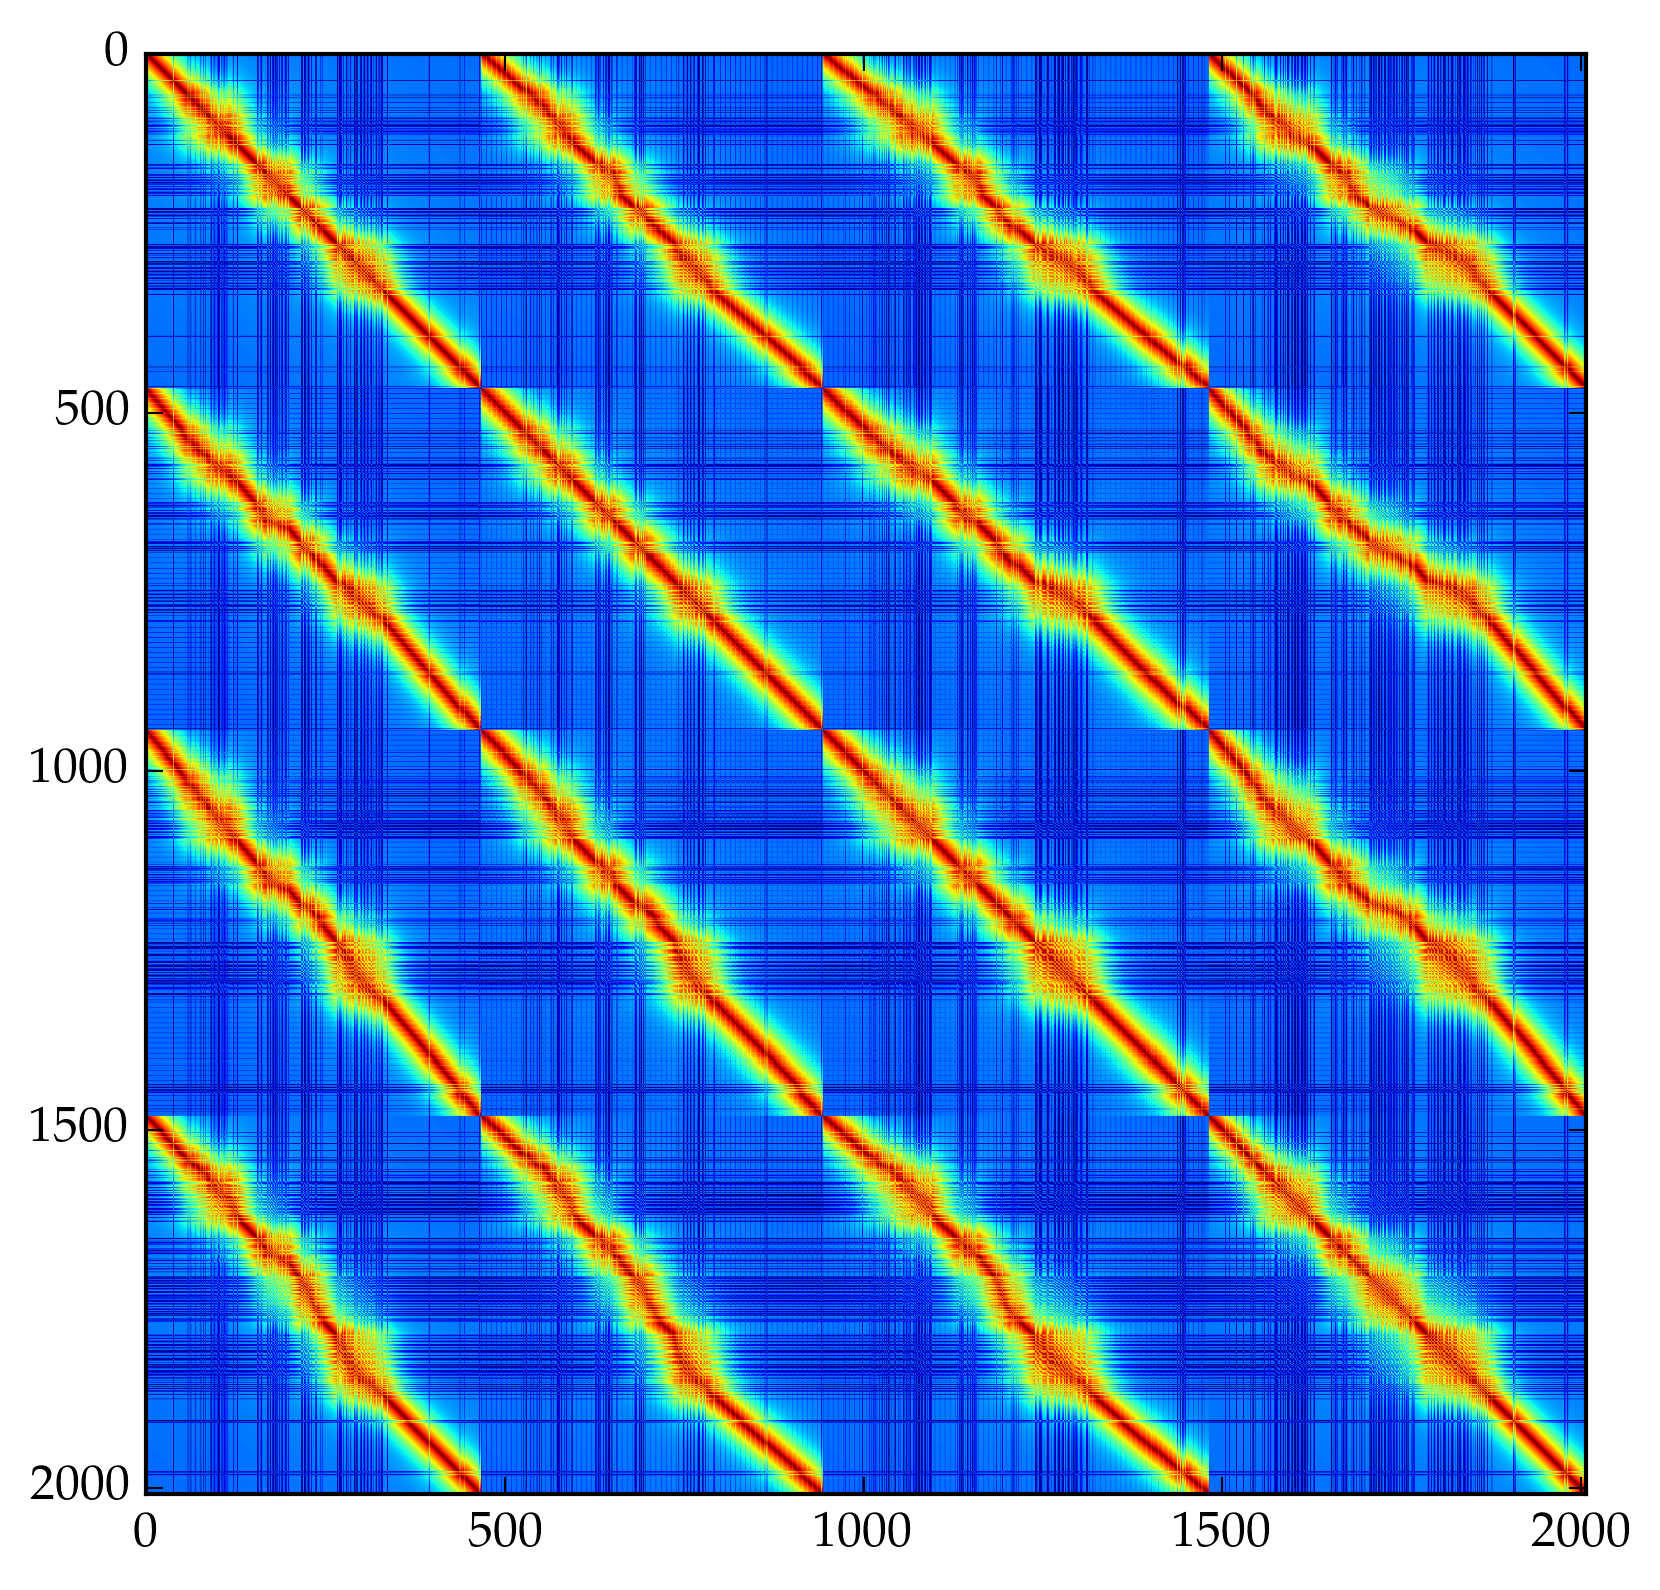

In [21]:
time = convert(Vector{Float64},hourly_chunk[:ts_hours])
temp = convert(Vector{Float64},hourly_chunk[:temp])
station = convert(Vector{Int},hourly_chunk[:station])
μ = mean(temp)
cK_temporal = cov(k_time, time')
plt.imshow(cK_temporal)
;

# Using Masked kernels

In [22]:
chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

2008×3 Array{Float64,2}:
   0.866667  1.64799e6  1.0441e6 
   1.86667   1.64799e6  1.0441e6 
   2.86667   1.64799e6  1.0441e6 
   3.86667   1.64799e6  1.0441e6 
   4.86667   1.64799e6  1.0441e6 
   5.86667   1.64799e6  1.0441e6 
   6.86667   1.64799e6  1.0441e6 
   7.86667   1.64799e6  1.0441e6 
   8.86667   1.64799e6  1.0441e6 
   9.86667   1.64799e6  1.0441e6 
  10.8667    1.64799e6  1.0441e6 
  11.8667    1.64799e6  1.0441e6 
  12.8667    1.64799e6  1.0441e6 
   ⋮                             
 325.883     1.51407e6  1.18374e6
 326.883     1.51407e6  1.18374e6
 327.883     1.51407e6  1.18374e6
 328.883     1.51407e6  1.18374e6
 329.883     1.51407e6  1.18374e6
 330.883     1.51407e6  1.18374e6
 331.883     1.51407e6  1.18374e6
 332.85      1.51407e6  1.18374e6
 332.883     1.51407e6  1.18374e6
 333.883     1.51407e6  1.18374e6
 334.883     1.51407e6  1.18374e6
 335.883     1.51407e6  1.18374e6

In [64]:
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3])

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [12.2061,0.0]


In [65]:
GP(chunk_X', hourly_chunk[:temp].values, MeanConst(mean(hourly_chunk[:temp].values)), k_spatiotemporal, 0.0)

GP object:
  Dim = 3
  Number of observations = 132
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [-6.77803]
  Kernel:
    Type: GaussianProcesses.ProdKernel
      Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
      Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [12.2061,0.0]
  Input observations = 
[8736.87 8737.87 … 8758.88 8759.88; 1.64799e6 1.64799e6 … 1.51407e6 1.51407e6; 1.0441e6 1.0441e6 … 1.18374e6 1.18374e6]
  Output observations = [-6.7,-5.6,-5.6,-5.0,-5.6,-5.0,-5.0,-5.0,-5.0,-5.0  …  -13.3,-12.8,-11.7,-11.1,-10.0,-9.4,-8.9,-8.9,-9.4,-10.0]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -210.943

In [66]:
chunks=GP[]
chunk_width=24*10
tstart=0.0
tend=tstart+chunk_width
nobsv=0
while tstart < get(maximum(hourly_cat[:ts_hours]))
    in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
    hourly_chunk = hourly_cat[in_chunk,:]
    nobsv_chunk = sum(in_chunk)
    nobsv += nobsv_chunk
    
    chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
    chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
    chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

    μ = mean(temp)
    cK_temporal = cov(k_time, time')
    cK_buffer = Array(Float64, nobsv_chunk, nobsv_chunk)
    chunk = GP(chunk_X', hourly_chunk[:temp].values, MeanConst(mean(hourly_chunk[:temp].values)), k_spatiotemporal, 0.0)
    push!(chunks, chunk)
    
    tstart=tend
    tend+=chunk_width
end

In [51]:
include("src/TempModel.jl")

TempModel

In [67]:
reals = TempModel.GPRealisations(chunks);

In [53]:
@time update_mll_and_dmll!(reals.reals[1])

  5.706617 seconds (21.38 k allocations: 339.145 MB, 13.51% gc time)


# Fixed parameter Kernel

In [54]:
type FixedKern <: Kernel
    kern::Kernel
    free::Vector{Int}
end

cov(fk::FixedKern, args...) = cov(fk.kern, args...)
KernelData(fk::FixedKern, args...) = KernelData(fk.kern, args...)
kernel_data_key(fk::FixedKern, args...) = kernel_data_key(fk.kern, args...)
cov!(fk::FixedKern, args...) = cov!(fk.kern, args...)
addcov!(s, fk::FixedKern, args...) = addcov!(s, fk.kern, args...)
multcov!(s, fk::FixedKern, args...) = multcov!(s, fk.kern, args...)
function multcov!{M<:AbstractArray{Float64,2}}(
    cK::AbstractArray{Float64,2}, 
    fk::FixedKern, X::M, data::KernelData)
    return multcov!(cK, fk.kern, X, data)
end
function addcov!{M<:AbstractArray{Float64,2}}(
    cK::AbstractArray{Float64,2}, 
    fk::FixedKern, X::M, data::KernelData)
    return addcov!(cK, fk.kern, X, data)
end
grad_slice!{M1<:MatF64}(dK::M1, fk::FixedKern, args...) = grad_slice!(dK, fk.kern, args...)

get_params(fk::FixedKern) = get_params(fk.kern)[fk.free]
get_param_names(fk::FixedKern) = get_param_names(fk.kern)[fk.free]
function set_params!(fk::FixedKern, hyp)
    p = get_params(fk.kern)
    p[fk.free] = hyp
    set_params!(fk.kern, p)
end
num_params(fk::FixedKern) = length(fk.free)

function fix(k::Kernel, par::Symbol)
    npars = num_params(k)
    free = collect(1:npars)
    names = get_param_names(k)
    tofix = find(names.==par)[1]
    deleteat!(free, tofix)
    return FixedKern(k, free)
end
function fix(k::FixedKern, par::Symbol)
    free = k.free
    names = get_param_names(k)
    tofix = find(names.==par)[1]
    deleteat!(free, tofix)
    return FixedKern(k.kern, free)
end
function fix(k::Kernel)
    return FixedKern(k, Int[])
end

fix (generic function with 3 methods)

In [68]:
k_spt_2 = fix(Masked(k_time, [1])) * Masked(k_spatial, [2,3])

Type: GaussianProcesses.ProdKernel
  Type: FixedKern, Params: Float64[]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [12.2061,0.0]


In [69]:
reals.k = k_spt_2
TempModel.propagate_params!(reals)

In [70]:
@time update_mll_and_dmll!(reals)

 39.692976 seconds (473.82 k allocations: 5.072 GB, 5.99% gc time)


4-element Array{Float64,1}:
 -24721.0  
    131.466
   2152.51 
   5224.15 

In [71]:
@time opt_out=optimize!(reals, mean=false, show_trace=true, x_tol=1e-5, f_tol=1e-5);

Iter     Function value   Gradient norm 
     0     7.272222e+04     2.472095e+04
Base.LinAlg.PosDefException(422)
Base.LinAlg.PosDefException(1331)
     1     6.058253e+04     7.042797e+03
     2     5.925868e+04     4.905125e+03
     3     5.774091e+04     2.940927e+03
     4     5.747865e+04     1.316200e+03
     5     5.741371e+04     8.160743e+02
     6     5.739919e+04     2.569034e+02
     7     5.739374e+04     1.458456e+02
     8     5.739290e+04     4.398829e+01
     9     5.739289e+04     1.083438e+01
861.832523 seconds (8.20 M allocations: 100.977 GB, 1.67% gc time)


In [73]:
print(opt_out.minimum)

[-1.60692,11.4161,0.280207]

In [60]:
print(opt_out.minimum)

[-1.61161,11.3967,0.271682]

In [72]:
print("\nk: SEIso \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.σ2)
@printf("l: %5.3f\n", √k_spatial.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: SEIso 
σ: 1.323
l: 90772.052

σy: 0.201


This gives us a pretty convincing fit for the spatial component of the covariance. Note that the lengthscale is in feet, and 100 000 feet $\approx$ 19 miles. The noise standard deviation $\sigma_y$ has gone down a little bit.